XGBoost Parameter Tuning for Rent Listing Inqueries

Rental Listing Inquiries数据集是Kaggle平台上的一个分类竞赛任务，需要根据公寓的特征来预测其受欢迎程度（用户感兴趣程度分为高、中、低三类）。其中房屋的特征x共有14维，响应值y为用户对该公寓的感兴趣程度。评价标准为logloss。 数据链接：https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

# 1. 直接调用xgboost内嵌的cv寻找最佳的参数n_estimators

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

import pandas as pd 
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

# 读取数据

In [2]:
# path to where the data lies
#dpath = './data/'
train = pd.read_csv("RentListingInquries_FE_train.csv")
train.head()

,bathrooms,bedrooms,latitude,longitude,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,1.5,3,40.7145,-73.9425,3000,1200.0,750.000000,-1.5,4.5,2016,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2,40.7947,-73.9667,5465,2732.5,1821.666667,-1.0,3.0,2016,...,0,0,0,0,0,0,0,0,0,2
2,1.0,1,40.7388,-74.0018,2850,1425.0,1425.000000,0.0,2.0,2016,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,40.7539,-73.9677,3275,1637.5,1637.500000,0.0,2.0,2016,...,0,0,0,0,0,0,0,0,0,2
4,1.0,4,40.8241,-73.9493,3350,1675.0,670.000000,-3.0,5.0,2016,...,0,0,1,0,0,0,0,0,0,2


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Columns: 225 entries, bathrooms to interest_level
dtypes: float64(7), int64(218)
memory usage: 84.7 MB


In [4]:
train.describe()

,bathrooms,bedrooms,latitude,longitude,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
count,49352.00000,49352.000000,49352.000000,49352.000000,4.935200e+04,4.935200e+04,4.935200e+04,49352.000000,49352.000000,49352.0,...,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000,49352.000000
mean,1.21218,1.541640,40.741545,-73.955716,3.830174e+03,1.697863e+03,1.657567e+03,-0.329460,2.753820,2016.0,...,0.003080,0.000385,0.186477,0.009361,0.000446,0.028165,0.002026,0.001013,0.000952,1.616895
std,0.50142,1.115018,0.638535,1.177912,2.206687e+04,1.100477e+04,7.817996e+03,0.947732,1.446091,0.0,...,0.055412,0.019618,0.389495,0.101625,0.021109,0.165446,0.044969,0.031814,0.030846,0.626035
min,0.00000,0.000000,0.000000,-118.271000,4.300000e+01,2.150000e+01,4.300000e+01,-5.000000,0.000000,2016.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,1.000000,40.728300,-73.991700,2.500000e+03,1.225000e+03,1.066667e+03,-1.000000,2.000000,2016.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.00000,1.000000,40.751800,-73.977900,3.150000e+03,1.500000e+03,1.383417e+03,0.000000,2.000000,2016.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,1.00000,2.000000,40.774300,-73.954800,4.100000e+03,1.850000e+03,1.962500e+03,0.000000,4.000000,2016.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,10.00000,8.000000,44.883500,0.000000,4.490000e+06,2.245000e+06,1.496667e+06,8.000000,13.500000,2016.0,...,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


# 准备数据

In [5]:
y_train = train['interest_level']

train = train.drop([ "interest_level"], axis=1)
X_train = train

In [6]:
# 训练样本6w+，交叉验证太慢，用train_test_split估计模型性能
# from sklearn.model_selection import train_test_split
# X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, train_size = 0.33,random_state = 0)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [7]:
#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
def modelfit(alg, X_train, y_train, cv_folds=None, early_stopping_rounds=10):
    xgb_param = alg.get_xgb_params()
#     print(xgb_param)
    xgb_param['num_class'] = 3
    
    #直接调用xgboost，而非sklarn的wrapper类
    xgtrain = xgb.DMatrix(X_train, label = y_train)
        
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], 
                      folds =cv_folds, metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
    print(cvresult)
    cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    
    #最佳参数n_estimators
    n_estimators = cvresult.shape[0]
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = n_estimators)
    alg.fit(X_train, y_train, eval_metric='mlogloss')
        
    #Predict training set:
    #train_predprob = alg.predict_proba(X_train)
    #logloss = log_loss(y_train, train_predprob)

   #Print model report:
   # print ("logloss of train :" )
   # print logloss

In [8]:
#params = {"objective": "multi:softprob", "eval_metric":"mlogloss", "num_class": 9}
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample = 0.5,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)

modelfit(xgb1, X_train, y_train, cv_folds=kfold)

     train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0               1.036909            0.000196            1.037798   
1               0.985289            0.000450            0.987105   
2               0.940985            0.000386            0.943599   
3               0.902897            0.000453            0.906374   
4               0.869778            0.000154            0.874006   
5               0.840821            0.000409            0.845817   
6               0.815198            0.000494            0.821004   
7               0.793006            0.000834            0.799591   
8               0.773080            0.000926            0.780386   
9               0.755129            0.000676            0.763199   
10              0.739314            0.000645            0.748047   
11              0.725137            0.000636            0.734666   
12              0.712397            0.000504            0.722667   
13              0.700836            0.000437    

In [9]:
xgb1.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.7,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 238,
 'nthread': 1,
 'objective': 'multi:softprob',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 3,
 'silent': 1,
 'subsample': 0.5}

/home/shnu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


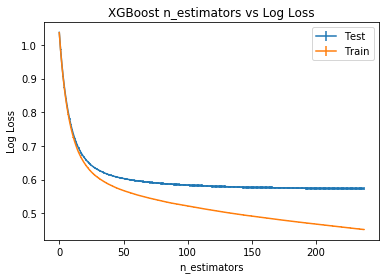

In [10]:
cvresult = pd.DataFrame.from_csv('1_nestimators.csv')
        
# plot
test_means = cvresult['test-mlogloss-mean']
test_stds = cvresult['test-mlogloss-std'] 
        
train_means = cvresult['train-mlogloss-mean']
train_stds = cvresult['train-mlogloss-std'] 

x_axis = range(0, cvresult.shape[0])
        
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel( 'n_estimators' )
pyplot.ylabel( 'Log Loss' )
pyplot.legend()
pyplot.savefig( 'n_estimators1_1.png' )

pyplot.show()

In [11]:
# 最佳参数n_estimators
n_estimators = cvresult.shape[0]
print("Best n_estimators:", n_estimators)

Best n_estimators: 238
